In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.9.1 True


In [2]:
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'

In [3]:
import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional



from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<_Logger detectron2 (DEBUG)>

In [4]:
# !pip install orjson

In [5]:
import json
with open("/kaggle/input/sartorius-coco-dataset-notebook/train_dataset.json") as f:
    val_data = json.loads(f.read())

all_val_img = []
for file_block in range(len(val_data["images"])):
    all_val_img.append(val_data["images"][file_block]["file_name"].replace("..","/kaggle"))

In [6]:
len(all_val_img)

575

In [7]:
Data_Resister_training="sartorius_Cell_train";
Data_Resister_valid="sartorius_Cell_valid";
from detectron2.data.datasets import register_coco_instances
# dataDir=Path('/kaggle/input/sartorius-cell-instance-segmentation')

register_coco_instances(Data_Resister_training,{}, '/kaggle/input/sartorius-coco-dataset-notebook/train_dataset.json', '')
register_coco_instances(Data_Resister_valid,{},'/kaggle/input/sartorius-coco-dataset-notebook/val_dataset.json', '')

metadata = MetadataCatalog.get(Data_Resister_training)
dataset_train = DatasetCatalog.get(Data_Resister_training)
dataset_valid = DatasetCatalog.get(Data_Resister_valid)

[12/30 16:37:19 d2.data.datasets.coco]: Loaded 575 images in COCO format from /kaggle/input/sartorius-coco-dataset-notebook/train_dataset.json
[12/30 16:37:19 d2.data.datasets.coco]: Loaded 31 images in COCO format from /kaggle/input/sartorius-coco-dataset-notebook/val_dataset.json


In [8]:
# dataset_valid[2] 

(520, 704, 3)


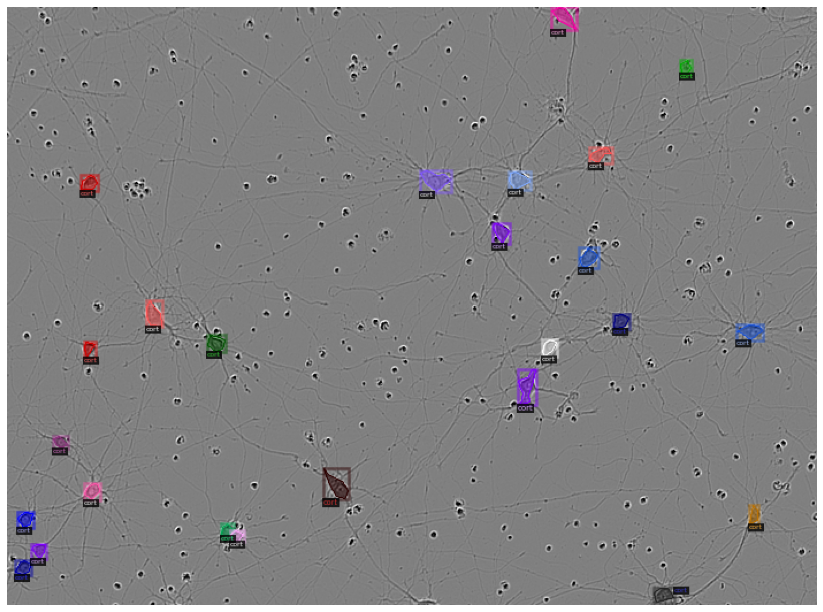

In [9]:
fig, ax = plt.subplots(figsize =(18,11))
d=dataset_valid[2] 
img = cv2.imread(d["file_name"])
print(img.shape)
v = Visualizer(img[:, :, ::-1],
                metadata=metadata, 
                scale=1,
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_dataset_dict(d)
ax.grid(False)
ax.axis('off')
ax.imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.data import transforms as T
# Define a sequence of augmentations:
augs = T.AugmentationList([
    T.RandomLighting(0.9)
#     T.RandomBrightness(0.9, 1.1),
#     T.RandomFlip(prob=0.5),
#     T.RandomRotation(-15,15)
#     T.RandomCrop("relative", (0.88, 0.9)),
#     T.RandomCrop("absolute", (500, 600))

])  # type: T.Augmentation

# Define the augmentation input ("image" required, others optional):
input = T.AugInput(img)
# Apply the augmentation:
transform = augs(input)  # type: T.Transform
image_transformed = input.image  # new image

(520, 704, 3)


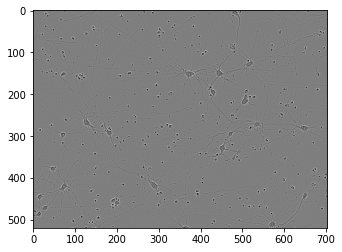

In [11]:
print(image_transformed.shape)
plt.imshow(image_transformed)

In [12]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
#             T.RandomBrightness(0.9, 1.1),
#             T.RandomContrast(0.9, 1.1),
#             T.RandomSaturation(0.9, 1.1),
#             T.RandomLighting(0.9),
            T.ResizeScale(0.8,1.4,520,704),
            T.RandomCrop("relative", (0.88, 0.9)),
            T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
            T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
#     instances = utils.annotations_to_instances(annos, image.shape[:2])
    instances = utils.annotations_to_instances(annos, image.shape[:2], mask_format="bitmask")
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

In [13]:
# Taken from https://www.kaggle.com/theoviel/competition-metric-map-iou
from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=1) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=0) == 0  # Extra objects
    return np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)

def score(pred, targ):
    pred_masks = pred['instances'].pred_masks.cpu().numpy()
    enc_preds = [mask_util.encode(np.asarray(p, order='F')) for p in pred_masks]
    enc_targs = list(map(lambda x:x['segmentation'], targ))
    ious = mask_util.iou(enc_preds, enc_targs, [0]*len(enc_targs))
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, ious)
        p = tp / (tp + fp + fn)
        prec.append(p)
    return np.mean(prec)

class MAPIOUEvaluator(DatasetEvaluator):
    def __init__(self, dataset_name):
        dataset_dicts = DatasetCatalog.get(dataset_name)
        self.annotations_cache = {item['image_id']:item['annotations'] for item in dataset_dicts}
            
    def reset(self):
        self.scores = []

    def process(self, inputs, outputs):
        for inp, out in zip(inputs, outputs):
            if len(out['instances']) == 0:
                self.scores.append(0)    
            else:
                targ = self.annotations_cache[inp['image_id']]
                self.scores.append(score(out, targ))

    def evaluate(self):
        return {"MaP IoU": np.mean(self.scores)}

class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return MAPIOUEvaluator(dataset_name)

In [14]:
os.makedirs("detectron2cell/output")

In [15]:
cfg = get_cfg()
config_name = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml" 
cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

# cfg.MODEL.WEIGHTS ="/kaggle/input/detectron2cell/output/model_final.pth"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64  # 64 is slower but more accurate (128 faster but less accurate)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
#cfg.SOLVER.MOMENTUM = 0.9
#cfg.SOLVER.WEIGHT_DECAY = 0.0005
#cfg.SOLVER.GAMMA = 0.1

    
cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 10000 #Maximum of iterations 1
cfg.SOLVER.STEPS = (500, 1000) #At which point to change the LR 0.25,0.5
cfg.TEST.EVAL_PERIOD = 250
cfg.SOLVER.CHECKPOINT_PERIOD=250

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = AugTrainer(cfg) # with  data augmentation  
# trainer = Trainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[12/30 16:37:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:19, 9.32MB/s]                           


[12/30 16:37:50 d2.engine.train_loop]: Starting training from iteration 0
[12/30 16:38:23 d2.utils.events]:  eta: 1:29:41  iter: 19  total_loss: 3.042  loss_cls: 0.9381  loss_box_reg: 0.482  loss_mask: 0.6822  loss_rpn_cls: 0.5162  loss_rpn_loc: 0.4005  time: 1.4258  data_time: 1.0601  lr: 0.0005  max_mem: 3886M
[12/30 16:38:40 d2.utils.events]:  eta: 1:21:22  iter: 39  total_loss: 2.603  loss_cls: 0.713  loss_box_reg: 0.6084  loss_mask: 0.5925  loss_rpn_cls: 0.4057  loss_rpn_loc: 0.3669  time: 1.1390  data_time: 0.6424  lr: 0.0005  max_mem: 3886M
[12/30 16:39:04 d2.utils.events]:  eta: 1:26:24  iter: 59  total_loss: 2.348  loss_cls: 0.6908  loss_box_reg: 0.6507  loss_mask: 0.4786  loss_rpn_cls: 0.2585  loss_rpn_loc: 0.3146  time: 1.1521  data_time: 0.9328  lr: 0.0005  max_mem: 3886M
[12/30 16:39:29 d2.utils.events]:  eta: 1:31:26  iter: 79  total_loss: 2.497  loss_cls: 0.6706  loss_box_reg: 0.721  loss_mask: 0.4478  loss_rpn_cls: 0.2461  loss_rpn_loc: 0.385  time: 1.1793  data_time: 0